### Cifar10 dataset loader


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(
    source, batch_size, transform, eval_transform=None, root="data", split_ratio=0.1
):
    if eval_transform is None:
        eval_transform = transform

    trainset = source(
        root=root,
        train=True,
        download=True,
        transform=transform,
    )
    testset = source(
        root=root,
        train=False,
        download=True,
        transform=eval_transform,
    )

    trainset, valset = torch.utils.data.random_split(
        trainset,
        [int((1 - split_ratio) * len(trainset)), int(split_ratio * len(trainset))],
    )

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, testloader


def get_cifar10_loaders(batch_size, root="data/cifar10", split_ratio=0.1):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    eval_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    return get_loaders(
        datasets.CIFAR10,
        batch_size,
        transform,
        eval_transform=eval_transform,
        root=root,
        split_ratio=split_ratio,
    )


DATALOADERS = {
    "cifar10": get_cifar10_loaders,
}

if __name__ == "__main__":
    datasets_to_load = ["cifar10"]
    for dataset in datasets_to_load:
        trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
        print(f'{dataset}: {len(trainloader.dataset)}, {len(valloader.dataset)}, {len(testloader.dataset)}, {trainloader.dataset[0][0].shape}')



cifar10: 45000, 5000, 10000, torch.Size([3, 32, 32])


#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



### VGG

#### Implement your model based on the given model architecture in the lab material.



In [ ]:
import torch.nn as nn

def replace_relu6_with_relu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU6):
            setattr(module, name, nn.ReLU(inplace=True))
        else:
            replace_relu6_with_relu(child)


In [38]:
import torch
import torch.nn as nn
import torch.quantization as tq
import torch.nn.functional as F

# ─── ① 手动实现 Conv+BN 参数折叠 ───────────────────────────────────────
def fuse_conv_bn(conv: nn.Conv2d, bn: nn.BatchNorm2d) -> nn.Conv2d:
    """返回一个新的 Conv2d，其 weight/bias 已经把 bn 参数 fold 进去了，带 bias=True。"""
    fused_conv = nn.Conv2d(
        conv.in_channels, conv.out_channels,
        conv.kernel_size, conv.stride, conv.padding,
        conv.dilation, conv.groups,
        bias=True
    )

    # 拷贝原 conv weight
    W = conv.weight.detach().clone()
    # 原 bias（如果没有就用 0）
    if conv.bias is not None:
        b = conv.bias.detach().clone()
    else:
        b = torch.zeros(conv.out_channels, device=W.device)

    # BN 参数
    gamma = bn.weight.detach().clone()
    beta  = bn.bias.detach().clone()
    mu    = bn.running_mean
    var   = bn.running_var
    eps   = bn.eps

    # fold 公式
    denom = torch.sqrt(var + eps)
    W_fold = W * (gamma / denom).reshape(-1, 1, 1, 1)
    b_fold = beta + (b - mu) * (gamma / denom)

    fused_conv.weight.data.copy_(W_fold)
    fused_conv.bias.data.copy_(b_fold)

    return fused_conv

# ─── ② 把一个 nn.Sequential 中的 Conv→BN→ReLU6 或 Conv→BN 序列替换成 fold 后的模块 ──
def fuse_sequential_conv_bn_relu6(seq: nn.Sequential) -> nn.Sequential:
    modules = []
    i = 0
    while i < len(seq):
        m1 = seq[i]
        # 检测 Conv→BN→ReLU6
        if (i + 2 < len(seq)
            and isinstance(m1, nn.Conv2d)
            and isinstance(seq[i+1], nn.BatchNorm2d)
            and isinstance(seq[i+2], nn.ReLU6)):
            # fold Conv+BN
            fused = fuse_conv_bn(m1, seq[i+1])
            # 保留原生 ReLU6
            modules.append(nn.Sequential(fused, seq[i+2]))
            i += 3
        # 检测仅 Conv→BN（如 bottleneck 最后一段 project）
        elif (i + 1 < len(seq)
              and isinstance(m1, nn.Conv2d)
              and isinstance(seq[i+1], nn.BatchNorm2d)):
            fused = fuse_conv_bn(m1, seq[i+1])
            modules.append(fused)
            i += 2
        else:
            modules.append(m1)
            i += 1
    return nn.Sequential(*modules)

# ─── ③ 给整个模型做一次遍历，把 features 以及每个 InvertedResidual.conv 都 fuse 掉 ───
def fuse_model(model: nn.Module) -> nn.Module:
    # 先 fuse 主干 features
    model.features = fuse_sequential_conv_bn_relu6(model.features)
    # 再 fuse 每个倒残差块里面的 conv
    for m in model.features:
        if isinstance(m, InvertedResidual):
            m.conv = fuse_sequential_conv_bn_relu6(m.conv)
    return model


#---------------------------------------------------------------------------#
# 1) 定义 Inverted Residual Block（倒残差块）
#---------------------------------------------------------------------------#
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = (self.stride == 1 and inp == oup)

        layers = []
        # 1x1 expand
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ]
        # 3x3 depthwise
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
        ]
        # 1x1 project
        layers += [
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

#---------------------------------------------------------------------------#
# 2) 定义 MobileNetV2 主干
#---------------------------------------------------------------------------#
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super().__init__()
        # 配置表：[t, c, n, s]
        inverted_residual_setting = [
            # t,   c,   n,  s
            [1,    16,  1,  1],
            [6,    24,  2,  2],
            [6,    32,  3,  2],
            [6,    64,  4,  2],
            [6,    96,  3,  1],
            [6,   160,  3,  2],
            [6,   320,  1,  1],
        ]

        # 首层 conv2d 3x3，输出 32 channel
        input_channel = int(32 * width_mult)
        layers = [
            nn.Conv2d(3, input_channel, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True)
        ]

        # 构建一系列倒残差块
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # 收尾：1x1 conv to 1280 -> avgpool -> fc
        last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280
        layers += [
            nn.Conv2d(input_channel, last_channel, 1, 1, 0, bias=False),
            nn.BatchNorm2d(last_channel),
            nn.ReLU6(inplace=True),
        ]
        self.features = nn.Sequential(*layers)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

        # 权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.classifier(x)
        return x







if __name__ == "__main__":
    model = MobileNetV2()
    inputs = torch.randn(1, 3, 32, 32)
    print(model)

    from torchsummary import summary

    summary(model, (3, 32, 32), device="cpu")


MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(96, 96, kernel_size=

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [39]:
from enum import Enum
import math

import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        #########Implement your code here##########
        # Handle edge cases
        if not math.isfinite(scale) or scale <= 0:
            return 1.0

        try:
            log2_scale = math.log2(scale)

            # Constrain log2_scale to prevent overflow
            log2_scale = max(min(log2_scale, max_shift_amount), -max_shift_amount)

            # Round to nearest power of two within constraints
            candidate = round(log2_scale)

            # Convert back to scale
            approx_scale = 2 ** candidate

            return approx_scale

        except (OverflowError, ValueError):
            # Fallback mechanism
            return 1.0
        ##########################################

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        # Find the absolute maximum to determine the range symmetrically
        abs_max = max(abs(min_val), abs(max_val))

        # Calculate the initial scale based on the full range
        scale = abs_max / (2 ** (self.dtype.itemsize * 8 - 1) - 1)

        # Determine zero point based on dtype
        #  0~255 : 128
        # -128~127 : 0
        if self.dtype == torch.qint8:
            zero_point = 0
        elif self.dtype == torch.quint8:
            zero_point = 128
        else:
            zero_point = 0  # Default fallback

        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=PowerOfTwo"


class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  1/50  lr=1.00e-03, train_loss=1.9761, val_loss=1.7680, train_acc=0.2567, val_acc=0.3482
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  2/50  lr=1.00e-03, train_loss=1.6852, val_loss=1.5532, train_acc=0.3714, val_acc=0.4238
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  3/50  lr=1.00e-03, train_loss=1.5293, val_loss=1.4958, train_acc=0.4414, val_acc=0.4682
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  4/50  lr=1.00e-03, train_loss=1.4016, val_loss=1.3613, train_acc=0.4981, val_acc=0.5072
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  5/50  lr=1.00e-03, train_loss=1.3075, val_loss=1.2577, train_acc=0.5328, val_acc=0.5548
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  6/50  lr=1.00e-03, train_loss=1.2215, val_loss=1.1908, train_acc=0.5662, val_acc=0.5812
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  7/50  lr=1.00e-03, train_loss=1.1375, val_loss=1.1208, train_acc=0.5985, val_acc=0.6094
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  8/50  lr=1.00e-03, train_loss=1.0784, val_loss=1.0377, train_acc=0.6226, val_acc=0.6410
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  9/50  lr=1.00e-03, train_loss=1.0205, val_loss=0.9720, train_acc=0.6444, val_acc=0.6674
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50  lr=1.00e-03, train_loss=0.9687, val_loss=0.9487, train_acc=0.6611, val_acc=0.6686
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50  lr=1.00e-03, train_loss=0.9281, val_loss=0.9194, train_acc=0.6773, val_acc=0.6838
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50  lr=1.00e-03, train_loss=0.8926, val_loss=0.9001, train_acc=0.6907, val_acc=0.7010
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50  lr=1.00e-03, train_loss=0.8660, val_loss=0.8687, train_acc=0.6998, val_acc=0.6926


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50  lr=1.00e-03, train_loss=0.8325, val_loss=0.8699, train_acc=0.7127, val_acc=0.6974


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50  lr=1.00e-03, train_loss=0.8052, val_loss=0.8832, train_acc=0.7214, val_acc=0.6956


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50  lr=1.00e-03, train_loss=0.7839, val_loss=0.7801, train_acc=0.7304, val_acc=0.7414
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50  lr=1.00e-03, train_loss=0.7643, val_loss=0.7662, train_acc=0.7364, val_acc=0.7416
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50  lr=1.00e-03, train_loss=0.7453, val_loss=0.7533, train_acc=0.7429, val_acc=0.7344


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50  lr=1.00e-03, train_loss=0.7313, val_loss=0.7391, train_acc=0.7492, val_acc=0.7430
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50  lr=1.00e-03, train_loss=0.7120, val_loss=0.7588, train_acc=0.7579, val_acc=0.7434
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50  lr=1.00e-03, train_loss=0.7126, val_loss=0.7124, train_acc=0.7567, val_acc=0.7562
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50  lr=1.00e-03, train_loss=0.6842, val_loss=0.6952, train_acc=0.7662, val_acc=0.7622
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50  lr=1.00e-03, train_loss=0.6764, val_loss=0.7162, train_acc=0.7680, val_acc=0.7510


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50  lr=1.00e-03, train_loss=0.6687, val_loss=0.6985, train_acc=0.7735, val_acc=0.7582


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50  lr=1.00e-03, train_loss=0.6538, val_loss=0.6735, train_acc=0.7775, val_acc=0.7718
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50  lr=1.00e-03, train_loss=0.6478, val_loss=0.6359, train_acc=0.7782, val_acc=0.7852
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50  lr=1.00e-03, train_loss=0.6348, val_loss=0.6435, train_acc=0.7843, val_acc=0.7810


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50  lr=1.00e-03, train_loss=0.6332, val_loss=0.6550, train_acc=0.7838, val_acc=0.7750


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50  lr=1.00e-03, train_loss=0.6264, val_loss=0.6416, train_acc=0.7859, val_acc=0.7838


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50  lr=2.00e-04, train_loss=0.5476, val_loss=0.5472, train_acc=0.8132, val_acc=0.8100
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50  lr=2.00e-04, train_loss=0.5151, val_loss=0.5235, train_acc=0.8230, val_acc=0.8214
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50  lr=2.00e-04, train_loss=0.5014, val_loss=0.5313, train_acc=0.8277, val_acc=0.8168


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50  lr=2.00e-04, train_loss=0.4993, val_loss=0.5443, train_acc=0.8279, val_acc=0.8126


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50  lr=2.00e-04, train_loss=0.4956, val_loss=0.5296, train_acc=0.8298, val_acc=0.8114


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50  lr=4.00e-05, train_loss=0.4765, val_loss=0.5122, train_acc=0.8368, val_acc=0.8206


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50  lr=4.00e-05, train_loss=0.4683, val_loss=0.5141, train_acc=0.8390, val_acc=0.8184


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50  lr=4.00e-05, train_loss=0.4639, val_loss=0.5215, train_acc=0.8397, val_acc=0.8174


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50  lr=4.00e-05, train_loss=0.4596, val_loss=0.5237, train_acc=0.8408, val_acc=0.8180


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50  lr=8.00e-06, train_loss=0.4634, val_loss=0.5028, train_acc=0.8406, val_acc=0.8238
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50  lr=8.00e-06, train_loss=0.4538, val_loss=0.5169, train_acc=0.8424, val_acc=0.8202


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50  lr=8.00e-06, train_loss=0.4594, val_loss=0.5110, train_acc=0.8420, val_acc=0.8264
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50  lr=8.00e-06, train_loss=0.4591, val_loss=0.5051, train_acc=0.8422, val_acc=0.8228


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50  lr=1.60e-06, train_loss=0.4599, val_loss=0.5082, train_acc=0.8411, val_acc=0.8192


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50  lr=1.60e-06, train_loss=0.4578, val_loss=0.5160, train_acc=0.8434, val_acc=0.8218


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50  lr=1.60e-06, train_loss=0.4633, val_loss=0.5040, train_acc=0.8405, val_acc=0.8244


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50  lr=3.20e-07, train_loss=0.4528, val_loss=0.5092, train_acc=0.8443, val_acc=0.8218


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50  lr=3.20e-07, train_loss=0.4576, val_loss=0.5150, train_acc=0.8407, val_acc=0.8228


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50  lr=3.20e-07, train_loss=0.4564, val_loss=0.5042, train_acc=0.8412, val_acc=0.8322
Model saved at weights/cifar10/mobilenetv2.pt (9.190262 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50  lr=6.40e-08, train_loss=0.4558, val_loss=0.5091, train_acc=0.8436, val_acc=0.8252


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50  lr=6.40e-08, train_loss=0.4575, val_loss=0.5009, train_acc=0.8425, val_acc=0.8232


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test: loss=0.4902, accuracy=0.8300
Model size: 9.19 MB
Plot saved at figure/cifar10/mobilenetv2-6.png
Time: 1953.63s


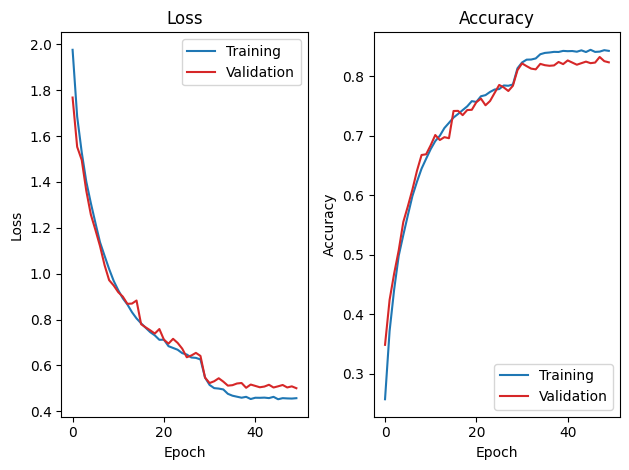

In [44]:
import os
import time
import torch
from torch import nn, optim
from tqdm.notebook import tqdm

DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reset_seed(20)

def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)
    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={optimizer.param_groups[0]['lr']:.2e}", end=", ")

        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")

        if _val_acc >= max(val_acc):
            save_model(model, save_path, existed="overwrite")

        if scheduler is not None:
            scheduler.step(_val_loss)

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc

def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = f"{dataset}/{network.__name__.lower()}"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(num_classes=10).to(DEFAULT_DEVICE)  # ✅ 對 mobilenet 輸入 num_classes

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=f"weights/{name}.pt",
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    print(f"Model size: {os.path.getsize(f'weights/{name}.pt') / 1e6:.2f} MB")

    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, f"figure/{name}.png")
    print(f"Time: {time.time() - t:.2f}s")

if __name__ == "__main__":
    for network in [MobileNetV2]:
        EPOCHS = 50
        main(epochs=EPOCHS, network=network, dataset="cifar10")


### PTQ on VGG Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [45]:
import torch
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx


def calibrate(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    print("Calibrating model with a few samples...")

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            model(images)
            if i == 20:
                break

    print("Calibration completed!")


def main(network, verbose=False):
    dataset = "cifar10"
    train_loader, val_loader, test_loader = DATALOADERS[dataset](batch_size=1)

    model_fp32 = network().eval().cpu()
    model_fp32.load_state_dict(torch.load("weights/cifar10/mobilenetv2.pt", map_location="cpu"))
    print("\nLoaded FP32 model===============================================================================")
    print(model_fp32)

    # 🔧 使用 FX Graph Mode 進行量化（支援殘差）
    # qconfig = torch.ao.quantization.get_default_qconfig("fbgemm")
    qconfig = CustomQConfig.POWER2.value  # 選擇 Power-of-Two 量化方案

    qconfig_dict = {"": qconfig}
    example_inputs = (torch.randn(1, 3, 32, 32),)  # CIFAR-10 輸入格式

    model_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs=example_inputs)

    # print("\nAfter prepare_fx:")
    # print(model_prepared)

    calibrate(model_prepared, test_loader)

    model_quantized = convert_fx(model_prepared)
    print("\nAfter convert_fx=================================================================================")
    print(model_quantized)

    quantized_model_path = "weights/cifar10/mobilenetv2-power2.pt"
    save_model(model_quantized, quantized_model_path, verbose=False, existed="overwrite")
    print(f"✅ Quantized model saved to {quantized_model_path}")


if __name__ == "__main__":
    main(network=MobileNetV2, verbose=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loaded FP32 model===============================================================================
MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, t

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(


Calibrating model with a few samples...
Calibration completed!

After convert_fx=================================================================================
GraphModule(
  (features): Module(
    (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.03125, zero_point=128, padding=(1, 1))
    (2): ReLU6(inplace=True)
    (3): Module(
      (conv): Module(
        (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0625, zero_point=128, padding=(1, 1), groups=32)
        (2): ReLU6(inplace=True)
        (3): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.0625, zero_point=128)
      )
    )
    (4): Module(
      (conv): Module(
        (0): QuantizedConv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.03125, zero_point=128)
        (2): ReLU6(inplace=True)
        (3): QuantizedConv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), scale=0.0625, zero_point=128, padding=(1, 1), groups=96)
        (5): ReLU6(inplace=True)
      

### Evaluate Quantized Model


In [46]:
def load_fx_model(
    model_class,
    model_path: str,
    example_input,
    qconfig=None,
    fuse_modules: bool = False,
    verbose: bool = True
) -> torch.nn.Module:
    model = model_class()
    model.eval()

    # 模組融合（如果有 fuse_modules 方法）
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    elif fuse_modules:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        # FX Graph Mode 量化
        qconfig_dict = {"": qconfig}
        model_prepared = prepare_fx(model, qconfig_dict, example_inputs=(example_input,))
        model_quantized = convert_fx(model_prepared)
        model_quantized.load_state_dict(torch.load(model_path, map_location="cpu"))
        model = model_quantized
        device = "cpu"
    else:
        # 非量化：直接載入模型參數
        model.load_state_dict(torch.load(model_path, map_location=DEFAULT_DEVICE))
        device = DEFAULT_DEVICE

    if verbose:
        print(f"Model loaded from {model_path} ({os.path.getsize(model_path) / 1e6:.2f} MB)")

    return model.to(device)

In [47]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

def main():
    dataset = 'cifar10'
    backend = 'power2'
    model_path = './weights/cifar10/mobilenetv2-power2.pt'

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
        print("Need Fuse Modules")
    else:
        qconfig = None
        fuse_modules = False

    example_input = torch.randn(1, 3, 32, 32)
    model = load_fx_model(MobileNetV2, model_path, example_input, qconfig, fuse_modules=fuse_modules)

    # print(model)

    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )


if __name__ == "__main__":
    main()



Need Fuse Modules
Model does not have 'fuse_modules' method. Skipping fusion.
Model loaded from ./weights/cifar10/mobilenetv2-power2.pt (2.35 MB)


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test: loss=0.5426, accuracy=0.8153, size=2.349272MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
